# Newell-Lee Evaporator: Rolling Horizon Simulation

Integrate the following IVP to simulate the Evaporator example from Pilario et al. (2021) in $t\in[0, 1000]$ min:

$$ \frac{dL_2}{dt} = \frac{F_1-F_4-F_2}{20}$$

$$ \frac{dX_2}{dt} = \frac{F_1 X_1 - F_2 X_2}{20} $$

$$ \frac{dP_2}{dt} = \frac{F_4 - F_5}{4} $$

$$ \begin{cases}
T_2 &= 0.5616P_2 + 0.3126X_2 + 48.43 \\
T_3 &= 0.507P_2 + 55.0 \\
F_4 &= \frac{Q_{100}-0.07F_1(T_2-T_1)}{38.5} \\
T_{100} &= 0.1538P_{100} + 90.0 \\
Q_{100} &= 0.16(F_1 + F_3)(T_{100}-T_2) \\
F_{100} &= Q_{100}/36.6 \\
Q_{200} &= \frac{0.9576F_{200}(T_3-T_{200})}{0.14F_{200}+6.84} \\
T_{201} &= T_{200} + \frac{Q_{200}}{0.07F_{200}} \\
F_5 &= Q_{200}/38.5 \\
\end{cases} $$

Apply piecewise step changes on F200, P100, and F2 inputs every 20 min.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def solve_model(ti, tf, F200data, P100data, F3data, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Manipulated variable to control L2 via P-control
    evap.F2 = Var(evap.t, initialize=2)
    
    # Inputs and Disturbances
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)

    evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.F3 = Param(evap.t, mutable=True)    # Input to be manipulated

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=1)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=25, ncp=3, scheme='LAGRANGE-RADAU')

    # P-controller
    def _p_control(m, i):
        if i > m.ti:
            return m.F2[i] == 2 + 5*(m.L2[m.t.prev(i)] - 1.0)
        else:
            return m.F2[i] == init_data['F2']

    evap.p_control = Constraint(evap.t, rule=_p_control)
    
    # Step change data
    timepoints = list(evap.t)
    if evap.ti.value == 0:
        F200data[0] = 208
        P100data[0] = 194.7
        F3data[0] = 50
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        evap.F200[t] = F200data[pos][0]
        evap.P100[t] = P100data[pos][0]
        evap.F3[t] = F3data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        s = pd.Series(v.extract_values(), 
                      index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'F200' or v.name == 'P100' or v.name == 'F3':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res

rand_seed = 10

np.random.seed(rand_seed)
i_data = np.arange(0, 1000, 50) # start, last, increment
F200data = (np.random.rand(i_data.shape[0])-0.5)*100 + 208
P100data = (np.random.rand(i_data.shape[0])-0.5)*100 + 194.7
F3data = (np.random.rand(i_data.shape[0])-0.5)*10 + 50

init_data = {'L2':1,    'P2':50.5, 'X2':25, 'F2':2,
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}

# Initialize the data frame
evap_df = pd.DataFrame(columns=['L2', 'P2', 'X2', 'dL2dt', 'dP2dt', 
                                'dX2dt', 'F200', 'P100', 'F3'])

# Set the horizon length and total time
hor_len = 25
total_time = 1000

for j in np.arange(0, total_time, hor_len): # start, last, increment
    
    # Simulate the model at time [j, j+hor_len]
    temp_df, res = solve_model(j, j+hor_len, F200data, P100data, F3data, init_data)
    print(f"Time: {j} min to {j+hor_len} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[-1][k]

    # Append temp_df after evap_df
    if j+hor_len < total_time:
        evap_df = pd.concat([evap_df, temp_df.iloc[:-1,:]], axis=0)
    else:
        evap_df = pd.concat([evap_df, temp_df], axis=0)
        

Please recompile / update your pynumero_ASL library.
Time: 0 min to 25 min
Status: ok
Time: 25 min to 50 min
Status: ok
Time: 50 min to 75 min
Status: ok
Time: 75 min to 100 min
Status: ok
Time: 100 min to 125 min
Status: ok
Time: 125 min to 150 min
Status: ok
Time: 150 min to 175 min
Status: ok
Time: 175 min to 200 min
Status: ok
Time: 200 min to 225 min
Status: ok
Time: 225 min to 250 min
Status: ok
Time: 250 min to 275 min
Status: ok
Time: 275 min to 300 min
Status: ok
Time: 300 min to 325 min
Status: ok
Time: 325 min to 350 min
Status: ok
Time: 350 min to 375 min
Status: ok
Time: 375 min to 400 min
Status: ok
Time: 400 min to 425 min
Status: ok
Time: 425 min to 450 min
Status: ok
Time: 450 min to 475 min
Status: ok
Time: 475 min to 500 min
Status: ok
Time: 500 min to 525 min
Status: ok
Time: 525 min to 550 min
Status: ok
Time: 550 min to 575 min
Status: ok
Time: 575 min to 600 min
Status: ok
Time: 600 min to 625 min
Status: ok
Time: 625 min to 650 min
Status: ok
Time: 650 min to 67

In [3]:
evap_df.shape

(3001, 19)

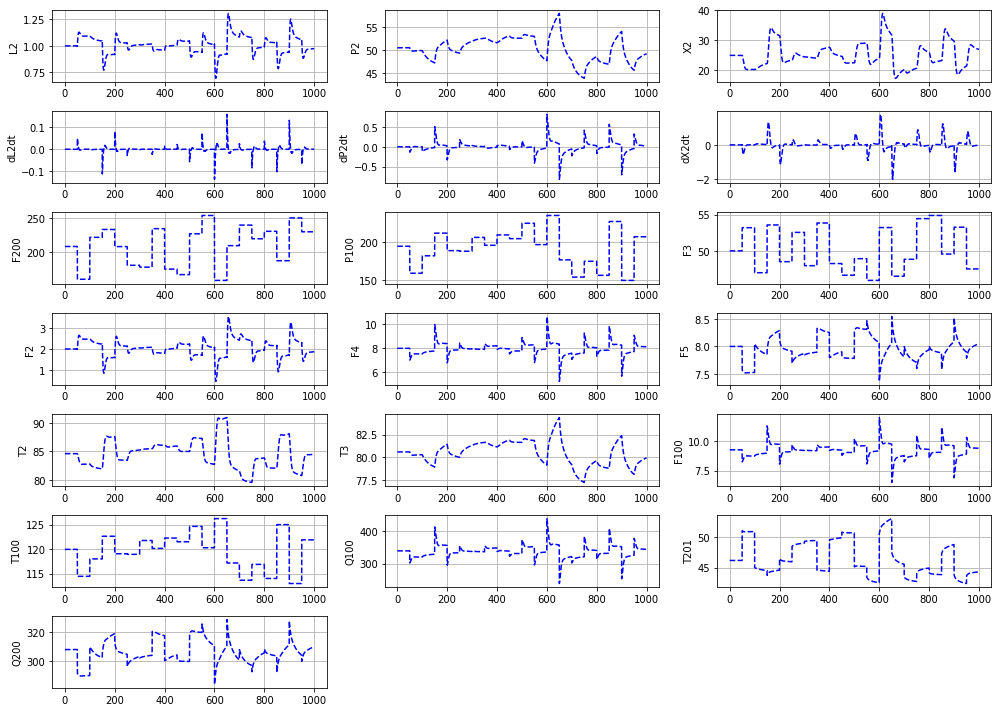

In [4]:
ctr = 1
plt.figure(figsize=(14, 10))
for k in evap_df.columns:
    plt.subplot(7, 3, ctr)
    plt.plot(evap_df[k].index, evap_df[k].values,'b--')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.grid()
    plt.ylabel(k)
    ctr += 1
    
plt.tight_layout()
plt.show()

In [5]:
evap_df.head(10)

,L2,P2,X2,dL2dt,dP2dt,dX2dt,F200,P100,F3,F2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200
0.000000,1.000000,50.500000,25.000000,-0.000040,0.000297,0.000000e+00,208.0,194.7,50.0,2.000000,8.000803,7.999617,84.605800,80.603500,9.269262,119.94486,339.254976,46.152833,307.985251
0.155051,0.999994,50.500046,25.000001,-0.000040,0.000294,-1.154694e-07,208.0,194.7,50.0,2.000000,8.000796,7.999620,84.605826,80.603523,9.269255,119.94486,339.254726,46.152842,307.985379
0.644949,0.999975,50.500188,25.000005,-0.000037,0.000286,3.794960e-05,208.0,194.7,50.0,1.999969,8.000774,7.999631,84.605907,80.603595,9.269234,119.94486,339.253949,46.152869,307.985778
1.000000,0.999962,50.500288,25.000037,-0.000032,0.000280,1.541571e-04,208.0,194.7,50.0,1.999874,8.000757,7.999638,84.605973,80.603646,9.269216,119.94486,339.253312,46.152889,307.986060
1.155051,0.999958,50.500331,25.000073,-0.000028,0.000277,2.273401e-04,208.0,194.7,50.0,1.999812,8.000747,7.999641,84.606009,80.603668,9.269207,119.94486,339.252971,46.152897,307.986181
1.644949,0.999945,50.500464,25.000184,-0.000025,0.000267,2.433285e-04,208.0,194.7,50.0,1.999791,8.000718,7.999651,84.606118,80.603735,9.269178,119.94486,339.251919,46.152923,307.986555
2.000000,0.999937,50.500558,25.000282,-0.000021,0.000260,3.163407e-04,208.0,194.7,50.0,1.999724,8.000696,7.999658,84.606201,80.603783,9.269156,119.94486,339.251122,46.152941,307.986817
2.155051,0.999934,50.500598,25.000339,-0.000018,0.000256,3.625343e-04,208.0,194.7,50.0,1.999683,8.000685,7.999661,84.606242,80.603803,9.269146,119.94486,339.250735,46.152948,307.986930
2.644949,0.999925,50.500721,25.000514,-0.000016,0.000246,3.629627e-04,208.0,194.7,50.0,1.999668,8.000652,7.999669,84.606366,80.603865,9.269113,119.94486,339.249547,46.152972,307.987275
3.000000,0.999920,50.500807,25.000649,-0.000013,0.000238,4.027889e-04,208.0,194.7,50.0,1.999626,8.000628,7.999676,84.606456,80.603909,9.269090,119.94486,339.248679,46.152989,307.987516


In [6]:
evap_df.tail(10)

,L2,P2,X2,dL2dt,dP2dt,dX2dt,F200,P100,F3,F2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200
997.000000,0.973307,49.150931,27.059819,0.000237,0.021214,-0.024818,229.457578,207.328715,47.513741,1.866101,8.129159,8.044302,84.492062,79.919522,9.402106,121.887156,344.117082,44.281847,309.705615
997.155051,0.973340,49.154213,27.055900,0.000223,0.021114,-0.025038,229.457578,207.328715,47.513741,1.866534,8.129001,8.044545,84.492680,79.921186,9.401951,121.887156,344.111396,44.282431,309.714997
997.644949,0.973456,49.164478,27.043894,0.000241,0.020794,-0.024145,229.457578,207.328715,47.513741,1.866702,8.128483,8.045308,84.494692,79.926390,9.401445,121.887156,344.092884,44.284258,309.744346
998.000000,0.973540,49.171820,27.035340,0.000231,0.020564,-0.024125,229.457578,207.328715,47.513741,1.867278,8.128110,8.045853,84.496141,79.930113,9.401080,121.887156,344.079545,44.285565,309.765338
998.155051,0.973573,49.175001,27.031531,0.000217,0.020467,-0.024338,229.457578,207.328715,47.513741,1.867699,8.127957,8.046089,84.496737,79.931726,9.400931,121.887156,344.074064,44.286132,309.774433
998.644949,0.973685,49.184952,27.019860,0.000234,0.020157,-0.023470,229.457578,207.328715,47.513741,1.867863,8.127458,8.046828,84.498677,79.936771,9.400443,121.887156,344.056211,44.287903,309.802883
999.000000,0.973766,49.192069,27.011546,0.000224,0.019935,-0.023449,229.457578,207.328715,47.513741,1.868423,8.127098,8.047357,84.500075,79.940379,9.400091,121.887156,344.043345,44.289170,309.823233
999.155051,0.973798,49.195153,27.007843,0.000211,0.019841,-0.023656,229.457578,207.328715,47.513741,1.868832,8.126951,8.047586,84.500650,79.941943,9.399947,121.887156,344.038059,44.289719,309.832050
999.644949,0.973907,49.204800,26.996500,0.000227,0.019542,-0.022810,229.457578,207.328715,47.513741,1.868991,8.126469,8.048302,84.502521,79.946834,9.399476,121.887156,344.020835,44.291436,309.859631
1000.000000,0.973986,49.211700,26.988420,0.000217,0.019327,-0.022788,229.457578,207.328715,47.513741,1.869534,8.126122,8.048815,84.503871,79.950332,9.399137,121.887156,344.008419,44.292664,309.879359


In [7]:
evap_df.to_csv(f'evap_seed{rand_seed}_in.csv') 